In [1]:
import numpy as np

from scipy.signal import fftconvolve
from scipy.interpolate import interp1d
from scipy.optimize import minimize

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import utils

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Data
---------

In [2]:
# Data extracted from Fig. 3a in Jensen et al. (2005)
jensen2005 = dict()
jensen2005['E125'] = dict()
jensen2005['E500'] = dict()

# Axons
jensen2005['E125']['axon'] = np.array([0.10000, 2.99614, 0.19835, 1.59634, 0.49824,
                                   0.72339, 1.00000, 0.54247, 2.00708, 0.48697,
                                   5.04155, 0.46555, 10.00000, 0.46976, 20.30918,
                                   0.46976, 50.41550, 0.46555]).reshape((-1, 2))
jensen2005['E125']['axon'][:, 0] /= 1000.0  # convert ms to s

jensen2005['E500']['axon'] = np.array([0.09883, 20.86371, 0.19535, 8.69288, 0.48840,
                                   4.50809, 0.98832, 2.93549, 1.90815, 2.31750,
                                   4.88400, 2.19890, 9.54095, 2.08637, 19.08149,
                                   2.06818, 47.70583, 1.99701]).reshape((-1, 2))
jensen2005['E500']['axon'][:, 0] /= 1000.0  # from ms to s


# SL cells
# The SL cell responses were typically a single action potential, although a few cells elicited
# a second action potential that immediately followed the first.
jensen2005['E125']['SL'] = np.array([0.10239, 0.74318, 0.19372, 0.62082, 0.49824,
                                 0.46976, 1.00000, 0.37855, 1.96023, 0.39954,
                                 5.04155, 0.40679, 10.00000, 0.39954, 19.83517,
                                 0.39242, 49.82369, 0.35866]).reshape((-1, 2))
jensen2005['E125']['SL'][:, 0] /= 1000.0  # from ms to s

jensen2005['E500']['SL'] = np.array([0.09883, 6.86281, 0.20000, 4.50809, 0.47706,
                                 2.83447, 0.98832, 2.01457, 1.93070, 2.05016,
                                 4.77058, 1.99701, 9.54095, 2.01457, 19.08149,
                                 1.97960, 47.14866, 1.87830]).reshape((-1, 2))
jensen2005['E500']['SL'][:, 0] /= 1000.0  # from ms to s


# LL cells
# The LL cell responses consisted of one or more bursts of typically two to five action potentials
# after stimulation at or slightly above threshold current. Unlike the SL cell responses, the
# LL cell responses did not appear to be due to direct activation of RGCs but rather to
# presynaptic activation of retinal neurons.
# LL (delayed) responses have higher thresholds than SL (immediate) responses.
jensen2005['E125']['LL'] = np.array([0.09767, 15.26138, 0.19835, 9.13982, 0.49824,
                                 4.78286, 0.98826, 3.02321, 1.96023, 2.01691,
                                 4.92388, 0.93057, 10.00000, 0.67317, 19.60233,
                                 0.35227, 49.82369, 0.28133]).reshape((-1, 2))
jensen2005['E125']['LL'][:, 0] /= 1000.0  # from ms to s

jensen2005['E500']['LL'] = np.array([0.09883, 53.70788, 0.20000, 36.53740, 0.48840, 
                                 12.23073, 0.96537, 8.76932, 1.90815, 6.39858,
                                 4.88400, 4.13019, 9.65370, 2.46397, 19.08149,
                                 1.81366, 47.70583, 0.96559]).reshape((-1, 2))
jensen2005['E500']['LL'][:, 0] /= 1000.0  # from ms to s

In [3]:
# Data extracted from Fig. 4

# Cathodic
jensen2005['E125']['cathodic'] = np.array([0.09790, 3.60377, 0.19721, 1.80616, 0.50172,
                                       0.83488, 0.98945, 0.65090, 1.99315, 0.60031,
                                       4.96424, 0.58921, 9.89445, 0.58921, 20.14408,
                                       0.58555, 51.24806, 0.58555]).reshape((-1, 2))
jensen2005['E125']['cathodic'][:, 0] /= 1000

jensen2005['E500']['cathodic'] = np.array([0.09674, 12.99098, 0.19533, 7.89559, 0.49841,
                                       4.14732, 0.98500, 2.61376, 1.98677, 1.97357,
                                       4.94956, 1.87169, 9.86591, 1.84259, 19.66889,
                                       1.74952, 48.99084, 1.73072]).reshape((-1, 2))
jensen2005['E500']['cathodic'][:, 0] /= 1000



# Anodic
jensen2005['E125']['anodic'] = np.array([0.10000, 8.94028, 0.19931, 5.57116, 0.50172,
                                     3.83516, 1.01067, 3.42874, 2.03590, 3.10379,
                                     5.01719, 3.14266, 10.21449, 3.12316, 20.35897,
                                     3.06540, 51.24806, 3.18202]).reshape((-1, 2))
jensen2005['E125']['anodic'][:, 0] /= 1000

jensen2005['E500']['anodic'] = np.array([0.09849, 26.77548, 0.19485, 13.42013, 0.49741, 6.40109, 0.98211, 4.95176,
                              1.93901, 3.87704, 4.93281, 3.90493, 9.83307, 3.79816, 20.02002, 3.76131,
                              50.94491, 3.56675]).reshape((-1, 2))
jensen2005['E500']['anodic'][:, 0] /= 1000

# Model
-----------------

Following are all utily funcions used in this script.

In [4]:
def gaussian(t, alpha, tau, t0=0, n=1):
    return alpha * ((t - t0) / tau) ** n * np.exp(-n * ((t - t0) / tau - 1))

def rgc_impulse(ampl_pos, ampl_min, tau_pos=0.817, tau_min=0.433, n=15, tsample=0.005):
    # TODO: make it work with seconds instead of milliseconds
    t = np.arange(0, 2.0, tsample)
    y = gaussian(t, ampl_pos, tau_pos, 0, n) - gaussian(t, ampl_min, tau_min, 0, n)
    return y

In [5]:
class GanglionCell(object):
    def __init__(self, tsample, ca_scale=1.0, ca_tau=0.0191,
                 inl_scale=0, inl_tau=5.0 / 1000, 
                 anodic_scale=0,
                 r_scale = 1,
                 axon_scale=1.0):
        assert ca_scale >= 0
        assert ca_tau > 0
        assert inl_scale >= 0
        assert inl_tau > 0
        assert anodic_scale >= 0
        assert axon_scale >= 0
        self.tsample = tsample
        self.ca_scale = ca_scale
        self.ca_tau = ca_tau
        self.inl_scale = inl_scale
        self.axon_scale = axon_scale
        self.r_scale = r_scale

        self.gamma_gcl = rgc_impulse(anodic_scale, 1.0, tsample=tsample * 1000)
        self.gamma_gcl /= np.trapz(np.abs(self.gamma_gcl), dx=tsample)
        
        if self.inl_scale > 0:
            self.inl_tau = inl_tau
            self.delay_inl = 40.0 / 1000
            t = np.arange(0, 10 * self.inl_tau, self.tsample)
            tmp_gamma = e2cm.gamma(2, 10 * self.inl_tau, t)
            tmp_gamma /= np.trapz(np.abs(tmp_gamma), dx=tsample)
            delay = np.zeros(int(np.round(self.delay_inl / self.tsample)))
            t = np.concatenate((delay, t))
            self.gamma_inl = np.concatenate((delay, tmp_gamma))

        if self.ca_scale > 0:
            t = np.arange(0, 10 * self.ca_tau, self.tsample)
            self.gamma_ca = e2cm.gamma(1, self.ca_tau, t)
            self.gamma_ca /= np.trapz(self.gamma_ca, dx=self.tsample)

        
    def model_cascade(self, pt, isaxon=False):
        assert pt.tsample == self.tsample
        
        if isaxon:
            pt.data *= self.axon_scale
            
        pt.data *= self.r_scale
        
        # Calculate charge accumulation on electrode
        self.stim = pt
        
        # TODO: what if charge accum grows slower for anodic
        if self.ca_scale > 0:
            self.ca = pt.tsample * utils.sparseconv(self.gamma_ca, np.abs(pt.data), mode='full')[:pt.data.size]
        else:
            self.ca = 0

        # Calculate SL response (GCL)
        self.r_gcl_lin = pt.tsample * utils.sparseconv(self.gamma_gcl, pt.data)[:pt.data.size]

        # Calculate LL response (INL)
        if self.inl_scale > 0:
            self.r_inl_lin = pt.tsample * utils.sparseconv(self.gamma_inl, pt.data)[:pt.data.size]
            self.r_inl_lin = pt.tsample * fftconvolve(self.gamma_gcl, self.r_inl_lin, mode='full')[:pt.data.size]
        else:
            self.r_inl_lin = 0

        # Sum up responses
        self.r_lin = self.r_gcl_lin + self.inl_scale * self.r_inl_lin

        # Adjust for accumulated charge
        self.r_adj = self.r_lin - self.ca_scale * self.ca
        
#         # Feed through logistic activation function
#         self.r_rgc = 100.0 / (1.0 + np.exp(-self.sig_a * self.r_adj + self.sig_b))
#         return utils.TimeSeries(pt.tsample, self.r_rgc)
        return utils.TimeSeries(pt.tsample, self.r_adj)

Helper
------

In [6]:
def fit_amps(x, y, match_y):
    x = np.array(x)
    y = np.array(y)
    # We are given a list of input values `x` and their corresponding output values
    # `y` = f(x). We want to find the `x` value for which f(x) = `match_y`.
    if np.allclose(y.ptp(), 0.0):
        return np.inf

    # Easiest way is to use interp1d as x = f(y)!
    f = interp1d(y.flatten(), x.flatten(), fill_value='extrapolate')
    return np.asscalar(f(match_y))

In [7]:
# Monophasic pulse train
def get_jensen2005_pt(ptype, freq, amp, pdur, stim_dur, tsample=0.005 / 1000):
    assert freq >= 0
    assert amp >= 0  # sign handled by mono pulse
    assert pdur > 0
    assert stim_dur >= 0
    
    delay_dur = 10.0 / 1000
    
    stim_size = int(round(stim_dur / tsample))
    if np.isclose(amp, 0.0) or np.isclose(freq, 0.0):
        return utils.TimeSeries(tsample, np.zeros(stim_size))
    
    envelope_dur = 1.0 / float(freq)
    assert envelope_dur > delay_dur
    num_envelopes = np.maximum(1, int(np.ceil(stim_dur * freq)))
    
    pulse_train = np.array([])
    for j in range(num_envelopes):
        # A single mono pulse
        pulse = e2cm.get_monophasic_pulse(ptype, pdur, tsample, delay_dur, envelope_dur) * amp
        pulse_train = np.concatenate((pulse_train, pulse), axis=0)
    pulse_train = pulse_train[:stim_size]
    assert not np.allclose(pulse_train, 0)
    
    return utils.TimeSeries(tsample, pulse_train)

In [8]:
def find_sl_ll(resp, stim, delay_inl, verbose=False):
    """Finds the SL and LL responses of a pulse train"""
    
    # Find stimulus on-set in stimulus
    idx_onset = np.where(np.abs(stim.data) == np.abs(stim.data).max())[0][0]
    dur_onset = idx_onset * stim.tsample
    
    # Translate to indexing of `resp` (might have different `tsample`)
    idx_onset = int(np.floor(dur_onset / resp.tsample))
    
    if verbose:
        print('stim onset: dur=%f, idx=%d' % (dur_onset, idx_onset))
        
    activity = resp.data.squeeze()
    
    # SL response within 10ms of stimulus onset
    sl_dur = 10.0 / 1000
    sl_size = int(np.round(sl_dur / resp.tsample))
    sl_resp = activity[idx_onset: idx_onset + sl_size]
    t_sl = (sl_resp.argmax() + idx_onset) * resp.tsample
    y_sl = sl_resp.max()
    
    # LL response after ~40ms of stimulus onset
    ll_delay = int(np.floor(delay_inl / resp.tsample))
    ll_resp = activity[idx_onset + ll_delay:]
    t_ll = (ll_resp.argmax() + idx_onset + ll_delay) * resp.tsample
    y_ll = ll_resp.max()
    
    if verbose:
        print('SL=%f at t=%f, LL=%f at t=%f' % (y_sl, t_sl, y_ll, t_ll))
        
    return [t_sl, y_sl], [t_ll, y_ll]

# Fit
----------

In [9]:
def run_jensen2005_fig3(model, rtype, pdurs, amps):
    # max pulse dur is 100ms
    stim_dur = 0.2
    
    # just one pulse, so we don't need charge accumulation
    stim_freq = 1.0
    
    gcr = model['gcr']
    tsample = gcr.tsample
    
    fig3 = dict()
    fig3['pulse_durs'] = pdurs
    
    if rtype == 'axon':
        isaxon = True
    else:
        isaxon = False
    
    resp = []
    for pd, amp in zip(pdurs, amps):
        stim = get_jensen2005_pt('cathodic', stim_freq, amp, pd, stim_dur, tsample)
        mov = gcr.model_cascade(stim, isaxon=isaxon)
        resp.append(mov.data.max())
#         sl_max, ll_max = find_sl_ll(mov, stim, gcr.delay_inl)
#         if rtype == 'LL':
#             resp.append(ll_max[1])
#         else:  # 'SL' or 'axon'
#             resp.append(sl_max[1])

    fig3['resp'] = np.array(resp)
    return fig3

In [10]:
def run_jensen2005_fig4(model, ptype, pdurs, amps):
    # max pulse dur is 100ms
    stim_dur = 0.2
    
    # just one pulse, so we don't need charge accumulation
    stim_freq = 1.0
    
    gcr = model['gcr']
    tsample = gcr.tsample
    
    fig4 = dict()
    fig4['pulse_durs'] = pdurs
    
    resp = []
    for pd, amp in zip(pdurs, amps):
        stim = get_jensen2005_pt(ptype, stim_freq, amp, pd, stim_dur, tsample)
        mov = gcr.model_cascade(stim, isaxon=True)
        resp.append(mov.data.max())

    fig4['resp'] = np.array(resp)
    return fig4

In [11]:
def mse_jensen2005_fig3(x, jensen2005):
    mse = 0
    for diam in [125.0, 500.0]:
        ename = 'E%.0f' % diam
        model = get_model(x, diam)
        for rtype in ['SL', 'axon']:
            fig3 = run_jensen2005_fig3(model, rtype, jensen2005[ename][rtype][:, 0],
                                      jensen2005[ename][rtype][:, 1])
            mse += np.sum((fig3['resp'] - model['out_th']) ** 2)
    return mse

In [12]:
def mse_jensen2005_fig4(x, jensen2005):
    mse = 0
    for diam in [125.0, 500.0]:
        ename = 'E%.0f' % diam
        for ptype in ['cathodic', 'anodic']:
            model = get_model(x, diam)
            fig4 = run_jensen2005_fig4(model, ptype, jensen2005[ename][ptype][:, 0],
                                      jensen2005[ename][ptype][:, 1])
            mse += np.sum((fig4['resp'] - model['out_th']) ** 2)
    return mse

In [13]:
def mse_all(x, jensen2005):
    mse = 0
    
    mse += mse_jensen2005_fig3(x, jensen2005)
    mse += mse_jensen2005_fig4(x, jensen2005)
    
    print('%s: %.9f' % (str([('%.11f' % xx) for xx in x]), mse))
    return mse

In [14]:
def get_model(x, diam):
    tsample = 0.005 / 1000

    [r_scale, anodic_scale, axon_scale] = x
    model = dict()
    
    model['gcr'] = GanglionCell(tsample, ca_scale=0,
                                inl_scale=0,
                                r_scale=r_scale / diam,
                                anodic_scale=anodic_scale,
                                axon_scale=axon_scale)
    
    model['out_th'] = 1.0
    
    return model

In [15]:
# Version where charge accumulation depends on input pulse

# Good starting points:
# ['14.694249653', '9.769784529', '0.454416381', '0.300000000', '4.675693873']
res = minimize(mse_all, [1.0, 0.5, 1.0], args=(jensen2005),
               method='L-BFGS-B', bounds=[(1e-5, 1e5), (1e-5, 1e5), (1e-5, 1e5)])

['1.00000000000', '0.50000000000', '1.00000000000']: 71.409730872
['1.00000001000', '0.50000000000', '1.00000000000']: 71.409730866
['1.00000000000', '0.50000001000', '1.00000000000']: 71.409730872
['1.00000000000', '0.50000000000', '1.00000001000']: 71.409730867
['1.58831659544', '0.50931947852', '1.51565081094']: 70.644252283
['1.58831660544', '0.50931947852', '1.51565081094']: 70.644252274
['1.58831659544', '0.50931948852', '1.51565081094']: 70.644252282
['1.58831659544', '0.50931947852', '1.51565082094']: 70.644252275
['2.43485010540', '0.59183054317', '2.32753399384']: 68.919378085
['2.43485011540', '0.59183054317', '2.32753399384']: 68.919378073
['2.43485010540', '0.59183055317', '2.32753399384']: 68.919378083
['2.43485010540', '0.59183054317', '2.32753400384']: 68.919378073
['5.82098414523', '0.92187480176', '5.57506672547']: 57.018672782
['5.82098415523', '0.92187480176', '5.57506672547']: 57.018672761
['5.82098414523', '0.92187481176', '5.57506672547']: 57.018672793
['5.820984

# Plot
----------

In [16]:
# class Res:
#     def __init__(self, x):
#         self.x = x
# res = Res(np.array([0.019391848, 20.0, 0.009576861, 10.053760972, 0.491212852, 0.7, 4.649020953]))

In [17]:
# Some OK fits:
# - charge accum on RGC activity
#   [ 21.50166621   0.47054546   0.49898874]
# - charge accum on pulse train
print(res.x)

[  3.31017649e+02   2.30624750e-01   5.48347728e-01]


In [18]:
def run_jensen2005_fig3_findamp(model, rtype, pdurs):
    # max pulse dur is 100ms
    stim_dur = 0.2
    
    # just one pulse, so we don't need charge accumulation
    stim_freq = 1.0
    
    gcr = model['gcr']
    tsample = gcr.tsample
    
    fig3 = dict()
    fig3['pulse_durs'] = pdurs
    
    if rtype == 'axon':
        isaxon = True
    else:
        isaxon = False
    
    amp_match = []
    for pd in pdurs:
        # For every pulse duration, we need to find the current that gives
        # output == 1. Since output is linear, 2-3 data points should suffice
        # for intra/extrapolation. We also want "plausible" mA currents as
        # input:
        amp_search = [0.1, 1.0, 100.0]
        resp_search = []
        for amp in amp_search:
            stim = get_jensen2005_pt('cathodic', stim_freq, amp, pd, stim_dur, tsample)
            mov = gcr.model_cascade(stim, isaxon=isaxon)
            resp_search.append(mov.data.max())
#             sl_max, ll_max = find_sl_ll(mov, stim, gcr.delay_inl)
#             if rtype == 'LL':
#                 resp_search.append(ll_max[1])
#             else:  # 'SL' or 'axon'
#                 resp_search.append(sl_max[1])
        amp_match.append(fit_amps(amp_search, resp_search, model['out_th']))

    fig3['amp_match'] = np.array(amp_match)
    return fig3

In [19]:
def run_jensen2005_fig4_findamp(model, ptype, pdurs):
    # max pulse dur is 100ms
    stim_dur = 0.2
    
    # just one pulse, so we don't need charge accumulation
    stim_freq = 1.0
    
    gcr = model['gcr']
    tsample = gcr.tsample
    
    fig4 = dict()
    fig4['pulse_durs'] = pdurs
    
    amp_match = []
    for pd in pdurs:
        # For every pulse duration, we need to find the current that gives
        # output == 1. Since output is linear, 2-3 data points should suffice
        # for intra/extrapolation. We also want "plausible" mA currents as
        # input:
        amp_search = [0.1, 1.0, 100.0]
        resp_search = []
        for amp in amp_search:
            stim = get_jensen2005_pt(ptype, stim_freq, amp, pd, stim_dur, tsample)
            mov = gcr.model_cascade(stim, isaxon=True)
            resp_search.append(mov.data.max())
#             sl_max, _ = find_sl_ll(mov, stim, gcr.delay_inl)
#             resp_search.append(sl_max[1])
        amp_match.append(fit_amps(amp_search, resp_search, model['out_th']))
        
    fig4['amp_match'] = np.array(amp_match)
    return fig4

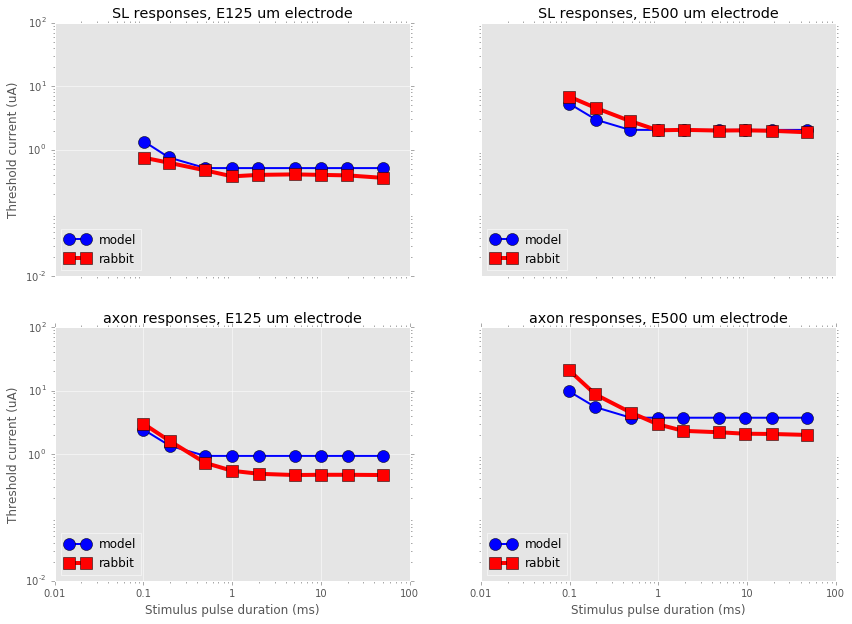

In [26]:
plt.figure(figsize=(14, 10))

subplot = 1
for rtype in ['SL', 'axon']:
    for diam in [125, 500]:
        ename = 'E%.0f' % diam
        model = get_model(res.x, diam)
        plt.subplot(2, 2, subplot)
        
        fig3 = run_jensen2005_fig3_findamp(model, rtype, jensen2005[ename][rtype][:, 0])

        plt.loglog(jensen2005[ename][rtype][:, 0], fig3['amp_match'],
                   'o-b', linewidth=2, markersize=12, label='model')
        plt.loglog(jensen2005[ename][rtype][:, 0], jensen2005[ename][rtype][:, 1],
                   's-r', linewidth=4, markersize=12, label='rabbit')
        
        plt.title('%s responses, %s um electrode' % (rtype, ename))
        plt.legend(loc='lower left')
        plt.xlim(0.01 / 1000, 100.0 / 1000)
        plt.ylim(0.01, 100)
        if subplot > 2:
            plt.xticks(np.array([0.01, 0.1, 1, 10, 100]) / 1000, [0.01, 0.1, 1, 10, 100])
            plt.xlabel('Stimulus pulse duration (ms)')
        else:
            plt.xticks([])
        if (subplot - 1) % 2 == 0:
            plt.yticks([0.01, 1, 10, 100])
            plt.ylabel('Threshold current (uA)')
        else:
            plt.yticks([])
        
        subplot += 1
plt.savefig('jensen2005_fig3.png')

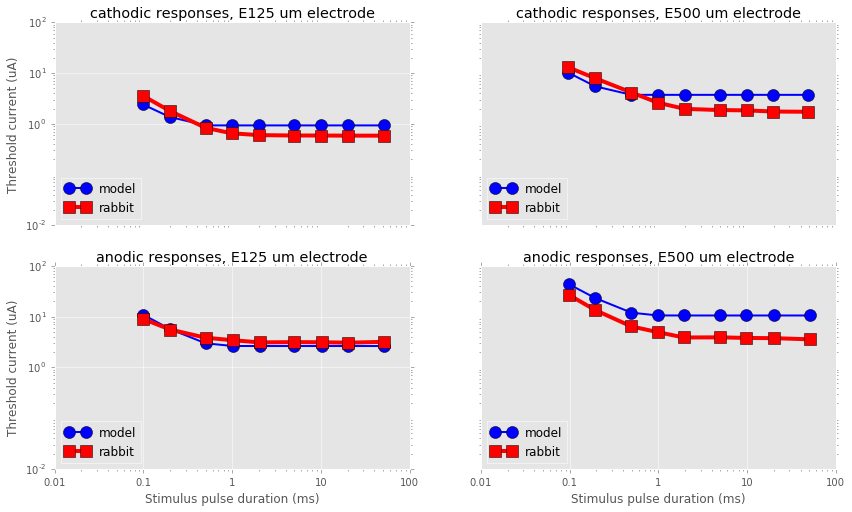

In [27]:
plt.figure(figsize=(14, 8))

subplot = 1
for ptype in ['cathodic', 'anodic']:
    for diam in [125, 500]:
        ename = 'E%.0f' % diam
        model = get_model(res.x, diam)
        plt.subplot(2, 2, subplot)
        
        fig4 = run_jensen2005_fig4_findamp(model, ptype, jensen2005[ename][ptype][:, 0])
        plt.loglog(jensen2005[ename][ptype][:, 0], fig4['amp_match'],
                   'o-b', linewidth=2, markersize=12, label='model')
        plt.loglog(jensen2005[ename][ptype][:, 0], jensen2005[ename][ptype][:, 1],
                   's-r', linewidth=4, markersize=12, label='rabbit')
        
        plt.title('%s responses, %s um electrode' % (ptype, ename))
        plt.legend(loc='lower left')
        plt.xlim(0.01 / 1000, 100.0 / 1000)
        plt.ylim(0.01, 100)
        if subplot > 2:
            plt.xticks(np.array([0.01, 0.1, 1, 10, 100]) / 1000, [0.01, 0.1, 1, 10, 100])
            plt.xlabel('Stimulus pulse duration (ms)')
        else:
            plt.xticks([])
        if (subplot - 1) % 2 == 0:
            plt.yticks([0.01, 1, 10, 100])
            plt.ylabel('Threshold current (uA)')
        else:
            plt.yticks([])
        
        subplot += 1
plt.savefig('jensen2005_fig4.png')

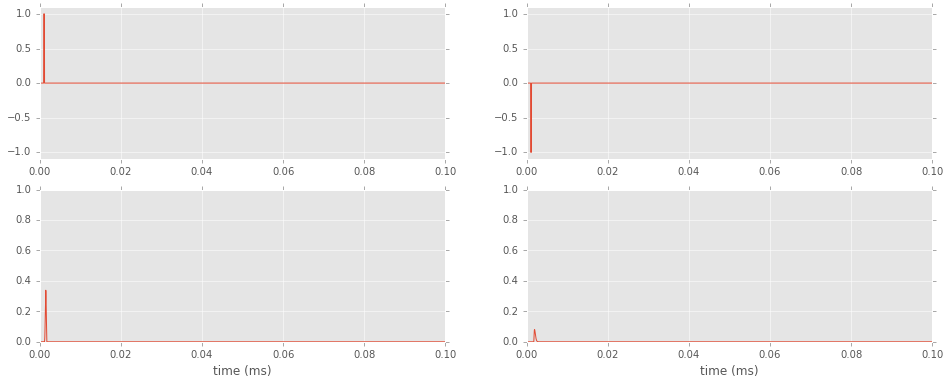

In [29]:
plt.figure(figsize=(16, 6))

dur = 0.1
delay = 1.0 / 1000
pdur = 0.2 / 1000
t = np.arange(0, dur, model['gcr'].tsample)

for i, ptype in enumerate(['cathodic', 'anodic']):
    plt.subplot(2, 2, i + 1)
    pt = e2cm.get_monophasic_pulse(ptype, pdur, tsample=model['gcr'].tsample, delay_dur=delay, stim_dur=dur)
    plt.plot(t, -pt)
    plt.ylim(-1.1, 1.1)
    
    plt.subplot(2, 2, i + 3)
    mov = model['gcr'].model_cascade(utils.TimeSeries(model['gcr'].tsample, pt))

    plt.plot(t, np.maximum(0, mov.data))
    plt.xlabel('time (ms)')
    plt.ylim(0, 1.0)
plt.savefig('jensen2005_SL_monophasic.png')

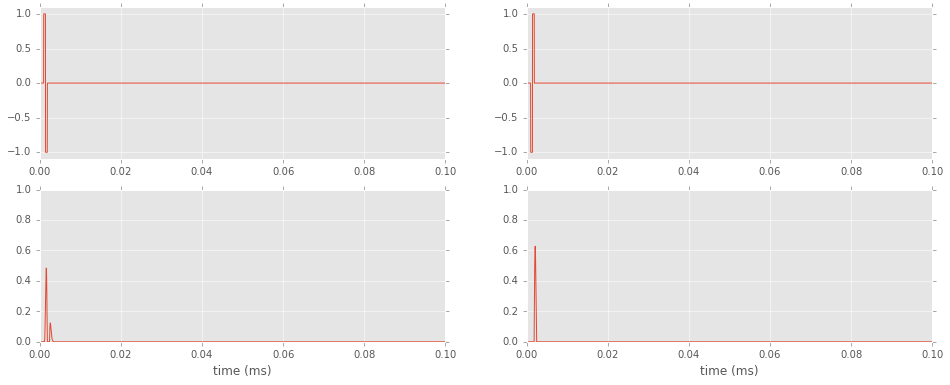

In [30]:
plt.figure(figsize=(16, 6))

gcr = model['gcr']

dur = 0.1
delay = 1.0 / 1000
pdur = 0.2 / 1000
idur = 0
t = np.arange(0, dur, gcr.tsample)

for i, ptype in enumerate(['cathodicfirst', 'anodicfirst']):
    plt.subplot(2, 2, i + 1)
    pt = e2cm.Psycho2Pulsetrain(gcr.tsample, 1, 1, dur=dur, delay=delay,
                                interphase_dur=idur, pulsetype=ptype)
    plt.plot(t, -pt.data)
    plt.ylim(-1.1, 1.1)
    
    plt.subplot(2, 2, i + 3)
    mov = gcr.model_cascade(pt)

    plt.plot(t, np.maximum(0, mov.data))
    plt.xlabel('time (ms)')
    plt.ylim(0, 1.0)
plt.savefig('jensen2005_SL_biphasic.png')